<a href="https://colab.research.google.com/github/katrina906/CS6120-Summarization-Project/blob/main/abstractive_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install import-ipynb

In [2]:
from transformers import pipeline
import pandas as pd
import torch
import import_ipynb
import numpy as np
import tensorflow as tf

In [3]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# load in functions from extract_summarization notebook
%cd "drive/MyDrive/Colab Notebooks"
from attention import *
%cd ..

/content/drive/MyDrive/Colab Notebooks
importing Jupyter notebook from attention.ipynb
/content/drive/MyDrive


In [7]:
# load data
df = pd.read_pickle("/content/drive/MyDrive/data/cleaned_df.pkl")
df = df.sample(frac = 1, random_state = 123).head(1000) # so comparable to extractive 10000. or only eval on ones we use for extractive? specific test set?
#article = df.iloc[0].text

In [8]:
# TODO split into train, validate, and test. supervised learning. validate for training, test for statistics

In [9]:
df[['sentences', 'sentences_summary']] # TODO use cleaned text
df['text_seq'] = df.sentences.map(lambda row: ' '.join(row))
df['summary_seq'] = df.sentences_summary.map(lambda row: '_START_ ' + ' '.join(row) + ' _END_')

In [10]:
from sklearn.model_selection import train_test_split
text_tr, text_test, summary_tr, summary_test = train_test_split(df['text_seq'].to_list(), df['summary_seq'].to_list(), test_size=0.1, random_state=0, shuffle=True) 
text_tr, text_val, summary_tr, summary_val = train_test_split(text_tr, summary_tr, test_size=0.1, random_state=0, shuffle=True) 

In [11]:
max_len_text = 100 # TODO set max len to actual max len 

In [12]:
def generate_token_sequences(text, tokenizer):
  seq = tokenizer.texts_to_sequences(list(text))
  seq = pad_sequences(seq,  maxlen=max_len_text, padding='post') 
  voc_size = len(tokenizer.word_index) 

  return seq, voc_size

In [13]:
# fit tokenizer on text training data. Same tokenizer for train and validation sets. 
# if word exists in validation but not in train, then will not be able to predict
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(text_tr))

tokenizer_summary = Tokenizer()
tokenizer_summary.fit_on_texts(list(summary_tr))

In [14]:
text_tr, text_tr_voc_size = generate_token_sequences(text_tr, tokenizer)
summary_tr, summary_tr_voc_size = generate_token_sequences(summary_tr, tokenizer_summary)
text_val, text_val_voc_size = generate_token_sequences(text_val, tokenizer)
summary_val, summary_val_voc_size = generate_token_sequences(summary_val, tokenizer_summary)

In [15]:
reverse_word_index_summary=tokenizer_summary.index_word 
reverse_word_index_text=tokenizer.index_word 
word_index_summary=tokenizer_summary.word_index

In [16]:
from keras import backend as K 
K.clear_session() 
latent_dim = 10 # 500 TODO tune?

In [17]:
# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(text_tr_voc_size+1, latent_dim,trainable=True)(encoder_inputs) 

In [18]:
#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# TODO different numbers of layers

In [19]:
# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(summary_tr_voc_size+1, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

In [20]:
#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(summary_tr_voc_size+1, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

In [21]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 10)      303950      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 10), (N 840         embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [22]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy') # TODO try diff optimizers, loss

In [23]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1) # TODO look at documentation

In [24]:
history=model.fit([text_tr,summary_tr[:,:-1]],
                  summary_tr.reshape(summary_tr.shape[0],summary_tr.shape[1], 1)[:,1:],
                  epochs=3, # 50
                  callbacks=[es],
                  batch_size=512, # 512
                  validation_data=([text_val,summary_val[:,:-1]], summary_val.reshape(summary_val.shape[0],summary_val.shape[1], 1)[:,1:]))
# https://keras.io/api/models/model_training_apis/#fit-method
# why is it using x and y as the x data?
# shifting summary data in both cases?

Epoch 1/3
2/2 [==============================] - 38s 2s/step - loss: 9.0104 - val_loss: 8.9987
Epoch 2/3
2/2 [==============================] - 1s 365ms/step - loss: 8.9981 - val_loss: 8.9822
Epoch 3/3
2/2 [==============================] - 1s 354ms/step - loss: 8.9820 - val_loss: 8.9564


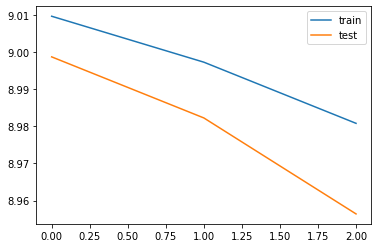

In [25]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [26]:

# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [27]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = word_index_summary['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, 1:]) # TODO added 1: to :
        sampled_token = reverse_word_index_summary[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [28]:
max_len_summary = 100

In [29]:
text_val[0]

array([    8,   481,    21,   562,   115,   151,  2937,   322,    43,
          21,    18,  2579,   253,     2,  2557,    39,     1,  1282,
          66,   151,   455,   672,  3981,    31,   229,     2,  1118,
           1,  6784,     3,    17,  8512,    26,    56,   974,    11,
          35,   912,   500,  3421,     6,  1166,    13,   101,    16,
          13,   927,    58,   470,     5,  2601,    19,     1,  2954,
         789,    15,    17,  2539, 28127,     5,   724,    31,  2416,
         304,    11,   640,   502,    14,   845,     1,  2525,     3,
           1,  1372,     7,     9,  8270,    11,    17,  1225,    63,
        5311,    17,  2539,     2,     5,  2920,  7469,     3,    46,
         493,   183,   467,    61,    21,  1066,     2,   128,    49,
         216], dtype=int32)

In [30]:
decode_sequence(text_val[0].reshape(1,max_len_text))

' said said said car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car car'

In [31]:
#summarizer = pipeline("summarization", framework = 'pt')
#summarized = summarizer(article, min_length=0, max_length=100) # max length is number of words/tokens
# max number of tokens can consider: 1024. Need to limit to first 1024
  # ok because best info tends to be at front of articles (and bcg documents bc pyramid principle)
  # potential extension is to fine tune with a higher max allowed

In [32]:
# https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/